# Lambda School Data Science - A First Look at Data



## Lecture - let's explore Python DS libraries and examples!

The Python Data Science ecosystem is huge. You've seen some of the big pieces - pandas, scikit-learn, matplotlib. What parts do you want to see more of?

In [0]:
# TODO - we'll be doing this live, taking requests
# and reproducing what it is to look up and learn things

List = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
print(List)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


## Assignment - now it's your turn

Pick at least one Python DS library, and using documentation/examples reproduce in this notebook something cool. It's OK if you don't fully understand it or get it 100% working, but do put in effort and look things up.

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example

import pandas as pd
import numpy as np

In [13]:
# CSV Data set import

from google.colab import files
uploaded = files.upload()

Saving world-happiness-report-2019.csv to world-happiness-report-2019.csv


In [19]:
df = pd.read_csv("world-happiness-report-2019.csv")
df.head()

,Country (region),Ladder,SD of Ladder,Positive affect,Negative affect,Social support,Freedom,Corruption,Generosity,Log of GDP per capita,Healthy life expectancy
0,Finland,1,4,41.0,10.0,2.0,5.0,4.0,47.0,22.0,27.0
1,Denmark,2,13,24.0,26.0,4.0,6.0,3.0,22.0,14.0,23.0
2,Norway,3,8,16.0,29.0,3.0,3.0,8.0,11.0,7.0,12.0
3,Iceland,4,9,3.0,3.0,1.0,7.0,45.0,3.0,15.0,13.0
4,Netherlands,5,1,12.0,25.0,15.0,19.0,12.0,7.0,12.0,18.0


In [20]:
## df.shape to find out how many columns and rows there
df.shape

(156, 11)

In [21]:
## See if there is NaN value
df.isnull()

,Country (region),Ladder,SD of Ladder,Positive affect,Negative affect,Social support,Freedom,Corruption,Generosity,Log of GDP per capita,Healthy life expectancy
0,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,False


In [26]:
# sort out by Freedom

df.sort_values(by='Freedom')

,Country (region),Ladder,SD of Ladder,Positive affect,Negative affect,Social support,Freedom,Corruption,Generosity,Log of GDP per capita,Healthy life expectancy
40,Uzbekistan,41,99,19.0,15.0,11.0,1.0,18.0,29.0,104.0,83.0
108,Cambodia,109,135,27.0,142.0,109.0,2.0,94.0,61.0,116.0,102.0
2,Norway,3,8,16.0,29.0,3.0,3.0,8.0,11.0,7.0,12.0
20,United Arab Emirates,21,65,43.0,56.0,72.0,4.0,NaN,15.0,4.0,60.0
0,Finland,1,4,41.0,10.0,2.0,5.0,4.0,47.0,22.0,27.0
1,Denmark,2,13,24.0,26.0,4.0,6.0,3.0,22.0,14.0,23.0
3,Iceland,4,9,3.0,3.0,1.0,7.0,45.0,3.0,15.0,13.0
7,New Zealand,8,15,22.0,12.0,5.0,8.0,5.0,8.0,26.0,14.0
8,Canada,9,23,18.0,49.0,20.0,9.0,11.0,14.0,19.0,8.0
6,Sweden,7,18,34.0,8.0,25.0,10.0,6.0,17.0,13.0,17.0


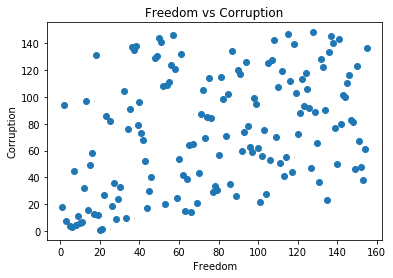

In [48]:
## import metaplotlib

import matplotlib.pyplot as plt

x = df['Freedom']
y = df['Corruption']
plt.plot(x,y, 'o')
plt.xlabel('Freedom')
plt.ylabel('Corruption')
plt.title('Freedom vs Corruption')
plt.show()

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  Describe in a paragraph of text what you did and why, as if you were writing an email to somebody interested but nontechnical.

2.  What was the most challenging part of what you did?

3.  What was the most interesting thing you learned?

4.  What area would you like to explore with more time?




1. Explained in code section
2. Plot the graph as X vs Y form
3. This big data set can be very easily managed with python library and makes much more organized and compare to it
4. I probably go look into 

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub (and since this is the first assignment of the sprint, open a PR as well).

- [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)
- [scikit-learn documentation](http://scikit-learn.org/stable/documentation.html)
- [matplotlib documentation](https://matplotlib.org/contents.html)
- [Awesome Data Science](https://github.com/bulutyazilim/awesome-datascience) - a list of many types of DS resources

Stretch goals:

- Find and read blogs, walkthroughs, and other examples of people working through cool things with data science - and share with your classmates!
- Write a blog post (Medium is a popular place to publish) introducing yourself as somebody learning data science, and talking about what you've learned already and what you're excited to learn more about.